In [15]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF

In [16]:
data = pd.read_csv("dataset.csv")
print(list(data.columns))
data.head()

['StudentID', 'CGPA', 'Internships', 'Projects', 'Workshops/Certifications', 'AptitudeTestScore', 'SoftSkillsRating', 'ExtracurricularActivities', 'PlacementTraining', 'SSC_Marks', 'HSC_Marks', 'PlacementStatus']


,StudentID,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
0,1,7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
1,2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
2,3,7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
3,4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
4,5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed


In [17]:
lb = LabelEncoder()
data['PlacementStatus'] = lb.fit_transform(data['PlacementStatus'])
data['PlacementTraining'] = lb.fit_transform(data['PlacementTraining'])
data['ExtracurricularActivities'] = lb.fit_transform(data['ExtracurricularActivities'])
data = data.drop(['StudentID'], axis = 1)
data = data.drop(['Workshops/Certifications'], axis = 1)
outputs = data['PlacementStatus']
inputs = data.drop(['PlacementStatus'], axis = 1)

In [18]:
data.isna().sum() # for checking nulls

CGPA                         0
Internships                  0
Projects                     0
AptitudeTestScore            0
SoftSkillsRating             0
ExtracurricularActivities    0
PlacementTraining            0
SSC_Marks                    0
HSC_Marks                    0
PlacementStatus              0
dtype: int64

In [19]:
data.describe()

,CGPA,Internships,Projects,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,7.698010,1.049200,2.026600,79.449900,4.323960,0.585400,0.731800,69.159400,74.501500,0.419700
std,0.640131,0.665901,0.867968,8.159997,0.411622,0.492677,0.443044,10.430459,8.919527,0.493534
min,6.500000,0.000000,0.000000,60.000000,3.000000,0.000000,0.000000,55.000000,57.000000,0.000000
25%,7.400000,1.000000,1.000000,73.000000,4.000000,0.000000,0.000000,59.000000,67.000000,0.000000
50%,7.700000,1.000000,2.000000,80.000000,4.400000,1.000000,1.000000,70.000000,73.000000,0.000000
75%,8.200000,1.000000,3.000000,87.000000,4.700000,1.000000,1.000000,78.000000,83.000000,1.000000
max,9.100000,2.000000,3.000000,90.000000,4.800000,1.000000,1.000000,90.000000,88.000000,1.000000


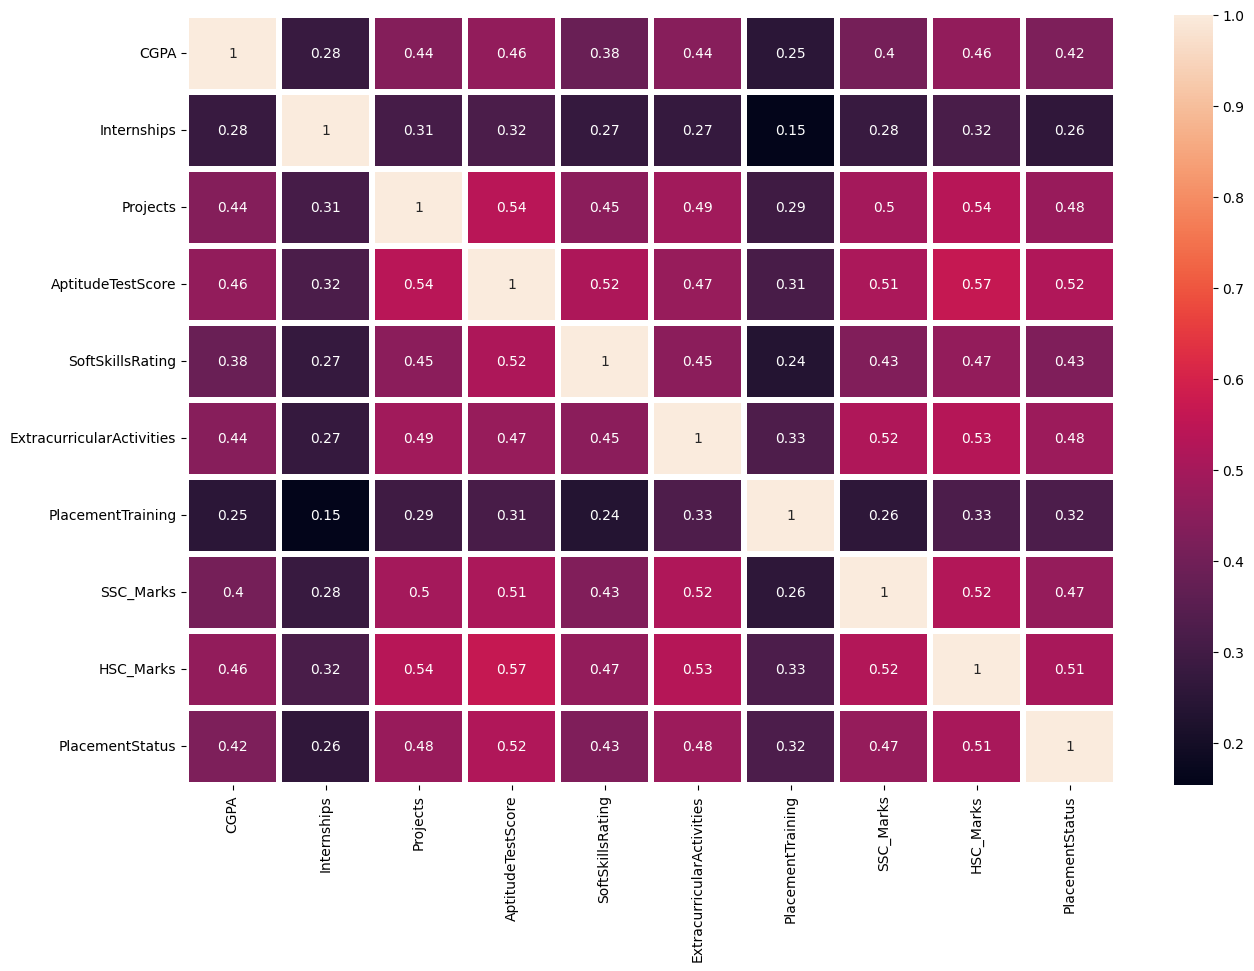

In [20]:
plt.figure(figsize = (15,10))
sns.heatmap(data.corr(),linewidths = 3, annot=True)
plt.show()

In [21]:
data

,CGPA,Internships,Projects,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
0,7.5,1,1,65,4.4,0,0,61,79,0
1,8.9,0,3,90,4.0,1,1,78,82,1
2,7.3,1,2,82,4.8,1,0,79,80,0
3,7.5,1,1,85,4.4,1,1,81,80,1
4,8.3,1,2,86,4.5,1,1,74,88,1
...,...,...,...,...,...,...,...,...,...,...
9995,7.5,1,1,72,3.9,1,0,85,66,0
9996,7.4,0,1,90,4.8,0,0,84,67,1
9997,8.4,1,3,70,4.8,1,1,79,81,1
9998,8.9,0,3,87,4.8,1,1,71,85,1


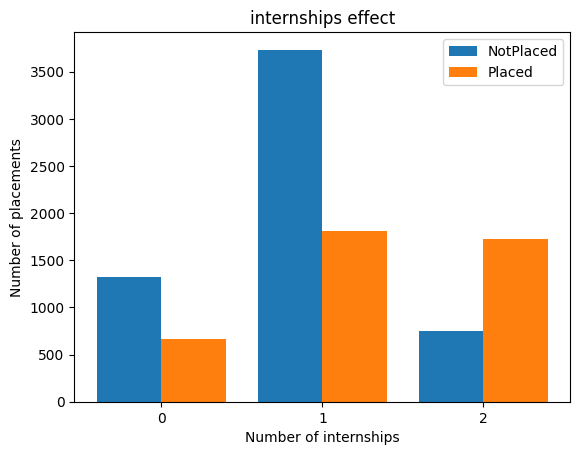

In [22]:
Internships_effect = data.pivot_table(index = 'PlacementStatus',values="CGPA", columns='Internships', aggfunc='count')
X = Internships_effect.columns
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, Internships_effect.iloc[0,:], 0.4, label = 'NotPlaced')
plt.bar(X_axis + 0.2, Internships_effect.iloc[1,:], 0.4, label = 'Placed')

plt.xticks(X_axis, X)
plt.xlabel("Number of internships")
plt.ylabel("Number of placements")
plt.title("internships effect")
plt.legend()
plt.show()

In [23]:
# Effect of CGPA and softskills
CGPA_effect = data.pivot_table(index = 'PlacementStatus', values= ['CGPA', 'SoftSkillsRating'])
CGPA_effect

,CGPA,SoftSkillsRating
PlacementStatus,,
0,7.467672,4.174393
1,8.016488,4.530760


Training and evaluating model: Support vector
Accuracy for Support vector: 79.73%


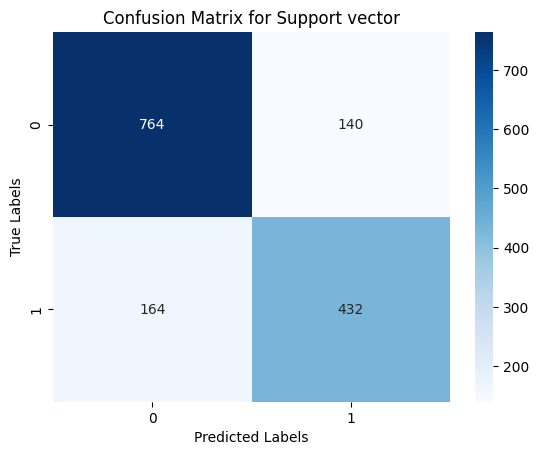



Training and evaluating model: Logistic regression
Accuracy for Logistic regression: 80.80%


C:\Users\acer\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


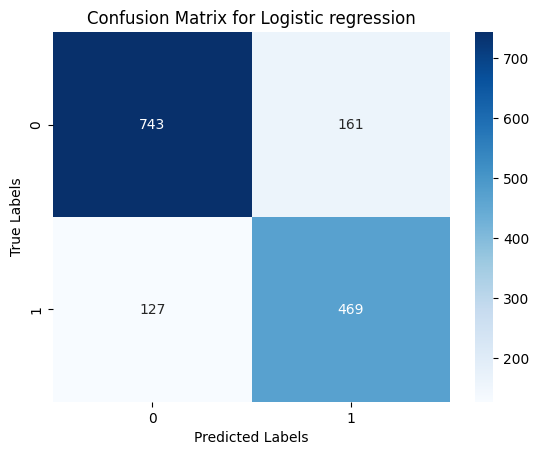



Training and evaluating model: Random Forest
Accuracy for Random Forest: 79.13%


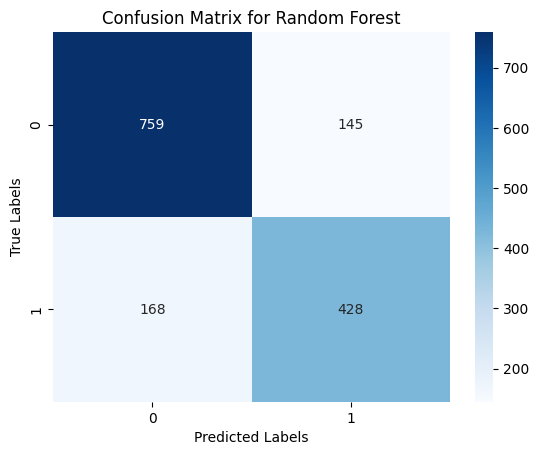



Training and evaluating model: Decision Trees
Accuracy for Decision Trees: 78.87%


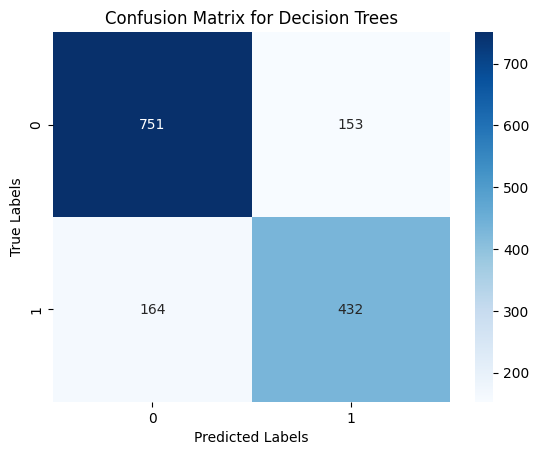



Training and evaluating model: Adaboost
Accuracy for Adaboost: 81.60%


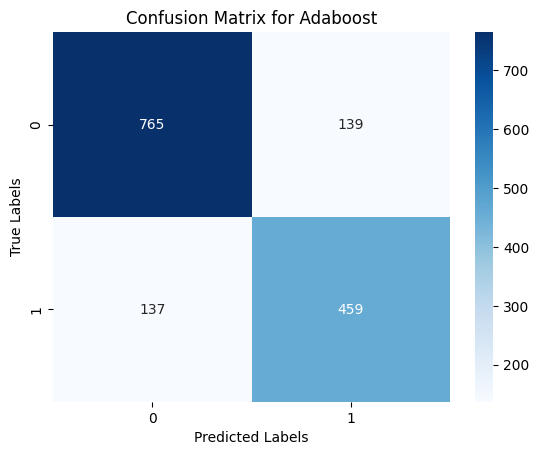



Model                    	Accuracy  	Precision 	Recall    	F1-Score  
Support vector           	79.73     	75.52     	72.48     	73.97     
Logistic regression      	80.80     	74.44     	78.69     	76.51     
Random Forest            	79.13     	74.69     	71.81     	73.22     
Decision Trees           	78.87     	73.85     	72.48     	73.16     
Adaboost                 	81.60     	76.76     	77.01     	76.88     


In [24]:
from sklearn.metrics import f1_score, precision_score, recall_score


X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size = 0.15, random_state = 0)
models = [[SVC(), "Support vector"],
         [LogisticRegression(C=10), "Logistic regression"],
         [RandomForestClassifier(n_estimators = 27), "Random Forest"],
         [DecisionTreeClassifier(max_depth = 10), "Decision Trees"],
         [AdaBoostClassifier(n_estimators = 30), "Adaboost"],
        ]

results = []

for model, modelname in models:
    print(f"Training and evaluating model: {modelname}")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    results.append([modelname, accuracy, precision, recall, f1])
    
    print(f"Accuracy for {modelname}: {accuracy * 100:.2f}%")
    
    cnf = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cnf, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"Confusion Matrix for {modelname}")
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    plt.show()
    print("\n")


print("{:<25}\t{:<10}\t{:<10}\t{:<10}\t{:<10}".format("Model", "Accuracy", "Precision", "Recall", "F1-Score"))
for modelname, accuracy, precision, recall, f1 in results:
    print("{:<25}\t{:<10.2f}\t{:<10.2f}\t{:<10.2f}\t{:<10.2f}".format(modelname, accuracy*100, precision*100, recall*100, f1*100))

In [25]:
model = AdaBoostClassifier()
grid = dict()
grid['n_estimators'] = [91,92,93,94,95,96,97]
grid['learning_rate'] = [ 0.01, 0.1,0.2,0.5, 1.0]
import pickle
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=15, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

with open('model.pkl', 'wb') as file:
    pickle.dump(grid_result, file)

Best: 0.796387 using {'learning_rate': 0.2, 'n_estimators': 92}


In [26]:
a=[[6.5,1,1,84,3.9,0,1,75,71]]
grid_result.predict(a)

C:\Users\acer\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


array([0])

In [27]:
for i in models:
    modelname = i[1]
    model = i[0]
    print(modelname)
    y_pred = model.predict(a)
    print(y_pred)
    print("\n")

Support vector
[0]


Logistic regression
[0]


Random Forest
[0]


Decision Trees
[0]


Adaboost
[0]




C:\Users\acer\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\acer\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\acer\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\acer\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\acer\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.war

In [28]:
X_test

,CGPA,Internships,Projects,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks
9394,7.7,0,2,74,4.0,1,1,90,84
898,8.5,1,3,77,4.7,1,1,65,85
2398,6.7,1,1,69,4.0,0,0,55,67
5906,6.5,1,2,76,4.3,1,1,69,73
2343,7.5,1,2,65,3.5,0,0,55,63
...,...,...,...,...,...,...,...,...,...
7990,7.9,0,2,80,3.6,0,0,60,86
5056,8.6,0,3,81,3.9,1,1,82,71
3910,6.8,1,1,76,4.1,0,0,55,62
1281,7.7,1,3,81,4.1,1,1,77,68
